# Sample; last 10 years

For the time being, to check the state of the network "at present", we get Eigg Obs. data for the lat 10 years

Note; later consider less granular method e.g. Genus or Phylum? [ASK JANE]

In [24]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians
from utils import *
from data import *
from collections import defaultdict
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [25]:
data = pd.read_csv("eigg.csv") 
print(data.columns)
data.head()

Index(['NBN Atlas record ID', 'Occurrence ID', 'Licence', 'Rightsholder',
       'Scientific name', 'Common name', 'Species ID (TVK)', 'Taxon Rank',
       'Occurrence status', 'Start date', 'Start date day', 'Start date month',
       'Start date year', 'End date', 'End date day', 'End date month',
       'End date year', 'Locality', 'OSGR', 'Latitude (WGS84)',
       'Longitude (WGS84)', 'Coordinate uncertainty (m)', 'Verbatim depth',
       'Recorder', 'Determiner', 'Individual count', 'Abundance',
       'Abundance scale', 'Organism scope', 'Organism remarks', 'Sex',
       'Life stage', 'Occurrence remarks',
       'Identification verification status', 'Basis of record', 'Survey key',
       'Dataset name', 'Dataset ID', 'Data provider', 'Data provider ID',
       'Institution code', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family',
       'Genus', 'OSGR 100km', 'OSGR 10km', 'OSGR 2km', 'OSGR 1km', 'Country',
       'State/Province'],
      dtype='object')


C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NBN Atlas record ID,Occurrence ID,Licence,Rightsholder,Scientific name,Common name,Species ID (TVK),Taxon Rank,Occurrence status,Start date,...,Class,Order,Family,Genus,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Country,State/Province
0,baa00bca-011f-43bf-b3e2-4ea60f04646e,3783,CC-BY-NC,Buglife,Meloe violaceus,Violet Oil-beetle,NBNSYS0000024952,species,present,28/06/1905,...,Insecta,Coleoptera,Meloidae,Meloe,NM,NM48,NM48T,NM4686,United Kingdom,Scotland
1,f70cff95-1d0d-4dbd-bece-10239bad0a93,232100298,CC0,NaN,Rhantus suturellus,NaN,NBNSYS0000007613,species,present,11/09/1910,...,Insecta,Coleoptera,Dytiscidae,Rhantus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
2,f450fbce-7e45-4822-ada4-0591c7ea0b48,232100297,CC0,NaN,Gyrinus substriatus,NaN,NBNSYS0000007643,species,present,11/09/1910,...,Insecta,Coleoptera,Gyrinidae,Gyrinus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
3,e6ceb7fa-7437-490f-a93e-862872492660,232100292,CC0,NaN,Enochrus fuscipennis,NaN,NHMSYS0001718079,species,present,11/09/1910,...,Insecta,Coleoptera,Hydrophilidae,Enochrus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
4,e6649320-d64b-4c29-8393-5565655f0ff9,232100296,CC0,NaN,Boreonectes multilineatus,NaN,NHMSYS0021125444,species,present,11/09/1910,...,Insecta,Coleoptera,Dytiscidae,Boreonectes,NM,NM48,NM48N,NM4486,United Kingdom,Scotland


In [26]:
subDf1 = data[['Scientific name', 'Common name', 'Species ID (TVK)', 'Start date year', 'Abundance']]
subDf1 = subDf1.dropna(subset=['Start date year'])
subDf1["Start date year"] = subDf1["Start date year"].astype(np.int32)
subDf1Year = subDf1[(subDf1['Start date year'] > 2010.0)]
subDf1Year.tail(100)
print(len(subDf1Year['Scientific name'].unique()))

1065


### We won't need abundance statistics if they're all implicitly 1

In [27]:
subDf1Year['Abundance'].unique()

array([nan, '1 adult female; 1 adult male'], dtype=object)

### Seemingly, Species ID is also a mapping to scientific name

In [28]:
len(subDf1Year['Scientific name'].unique()), len(subDf1Year['Species ID (TVK)'].unique())

(1065, 1066)

## Still have 35,000 records for 2010-present, so further constrain to last 5 years (for test network ERGM)

Also removing "Common name"column

In [29]:
subDf1Year = subDf1Year[['Scientific name', 'Common name','Start date year']]
subDf1Year["Start date year"] = subDf1Year["Start date year"].astype(np.int32)
finalDf = subDf1Year[(subDf1Year['Start date year'] > 2015.0)]
finalDf.tail()

,Scientific name,Common name,Start date year
27651,Arion (Mesarion) subfuscus,Dusky Slug,2019
27652,Arion (Kobeltia) owenii,Tawny Soil Slug,2019
27653,Deroceras invadens,Tramp Slug,2019
27654,Vespula vulgaris,Common Wasp,2019
28394,Meta menardi,Cave Spider,2016


In [30]:
print(len(finalDf))
print(len(finalDf['Scientific name'].unique()))
print(len(finalDf['Common name'].unique()))

160
33
32


In [31]:
scientific = list(finalDf['Scientific name'])
common = list(finalDf['Common name'])
scientific,common

(['Pieris napi',
  'Pieris napi',
  'Pieris napi',
  'Pieris napi',
  'Crex crex',
  'Crex crex',
  'Pieris napi',
  'Pieris napi',
  'Pieris napi',
  'Pieris napi',
  'Pieris napi',
  'Coenonympha pamphilus',
  'Pieris napi',
  'Pieris napi',
  'Pipistrellus pipistrellus',
  'Pieris napi',
  'Pipistrellus pipistrellus',
  'Coenonympha pamphilus',
  'Coenonympha pamphilus',
  'Boloria selene',
  'Coenonympha pamphilus',
  'Pieris napi',
  'Pipistrellus pipistrellus',
  'Pipistrellus pipistrellus',
  'Boloria selene',
  'Phocoena phocoena',
  'Maniola jurtina',
  'Pieris napi',
  'Pararge aegeria',
  'Polyommatus icarus',
  'Maniola jurtina',
  'Pieris napi',
  'Pararge aegeria',
  'Pieris napi',
  'Maniola jurtina',
  'Pieris napi',
  'Pieris napi',
  'Pieris napi',
  'Pieris napi',
  'Pieris napi',
  'Maniola jurtina',
  'Pieris napi',
  'Pieris napi',
  'Maniola jurtina',
  'Pieris napi',
  'Maniola jurtina',
  'Halichoerus grypus',
  'Phocoena phocoena',
  'Phocoena phocoena',
  'Ph

In [32]:
mapping = {}
for i in range(min(len(scientific), len(common))):
    mapping[scientific[i]] = common[i]
mapping['Delphinidae'] = "Dolphin"
mapping['Arion (Carinarion) circumscriptus'] = "Slug"

In [33]:
mapping

{'Aglais io': 'Peacock',
 'Argynnis aglaja': 'Dark Green Fritillary',
 'Arion (Arion) ater': 'Large Black Slug',
 'Arion (Arion) flagellus': 'Green-soled Slug',
 'Arion (Carinarion) circumscriptus': 'Slug',
 'Arion (Carinarion) fasciatus': 'Rusty False-keeled Slug',
 'Arion (Kobeltia) owenii': 'Tawny Soil Slug',
 'Arion (Mesarion) subfuscus': 'Dusky Slug',
 'Aurelia aurita': 'Moon jelly',
 'Balaenoptera acutorostrata': 'Minke Whale',
 'Boloria selene': 'Small Pearl-bordered Fritillary',
 'Bufo bufo': 'Common Toad',
 'Coenonympha pamphilus': 'Small Heath',
 'Crex crex': 'Corncrake',
 'Delphinidae': 'Dolphin',
 'Deroceras (Deroceras) reticulatum': 'Netted Field Slug',
 'Deroceras invadens': 'Tramp Slug',
 'Halichoerus grypus': 'Grey Seal',
 'Hyacinthoides non-scripta': 'Bluebell',
 'Hymenoscyphus fraxineus': 'Ash Dieback',
 'Lissotriton helveticus': 'Palmate Newt',
 'Maniola jurtina': 'Meadow Brown',
 'Meta menardi': 'Cave Spider',
 'Ocypus olens': "Devil's Coach-horse",
 'Omocestus viri

### We essentially have:

* Peacock
* Slugs (x8)
* Jellyfish
* Whale
* Toad
* Corncrake (bird)
* Dolphin
* Seal
* Plants- Bluebell & fungus
* Newt
* Spider
* Beetle
* Grasshopper
* Porpoise (= Dolphin?)
* Bat
* Wasp
* Remainder: butterflies

In [34]:
animals = list(mapping.values())
sls = (list(filter(lambda x:'slug' in x.lower(),animals)))
peacocks = [11]
slugs = [animals.index(x) for x in sls]
jellyfish = [13]
butterflies = [0,2,4,6,7,8,15,16, 17]
birds = [1]
bats = [3]
dolphins = [5,12]
seals = [9]
flowers = [10]
grasshopper = [14]
whales = [22]
toads = [23]
newts = [24]
beetles = [27]
fungus = [28]
wasps = [31]
spiders = [32]

## Assumed associations are:

* Peacock => Slugs, Newt, Grasshopper
* Slugs (x8)
* Jellyfish
* Whale 
* Toad => Slug, Grasshopper, Spider, Wasp, Beetle
* Corncrake (bird) => Slug, Grasshopper, Spider
* Dolphin
* Seal
* Plants [Bluebell & fungus] => 
* Newt => Slug, Grasshopper
* Spider => butterflies
* Beetle => Grasshopper
* Grasshopper
* Porpoise (= Dolphin?)
* Bat => 
* Wasp => butterflies
* Remainder: butterflies

In [35]:
G = nx.Graph()
for k,i in enumerate(mapping): G.add_node(k)

In [36]:
def addToGraph(Gm, from_,to_):
    for f in from_:
        for t in to_:
            Gm.add_edge(f,t)

addToGraph(G,peacocks,slugs+newts+grasshopper)
addToGraph(G,toads,slugs+grasshopper+spiders+wasps+beetles)
addToGraph(G,birds,slugs+grasshopper+spiders)
addToGraph(G,newts,slugs+grasshopper)
addToGraph(G,spiders,butterflies)
addToGraph(G,beetles,grasshopper)
addToGraph(G,wasps,butterflies)

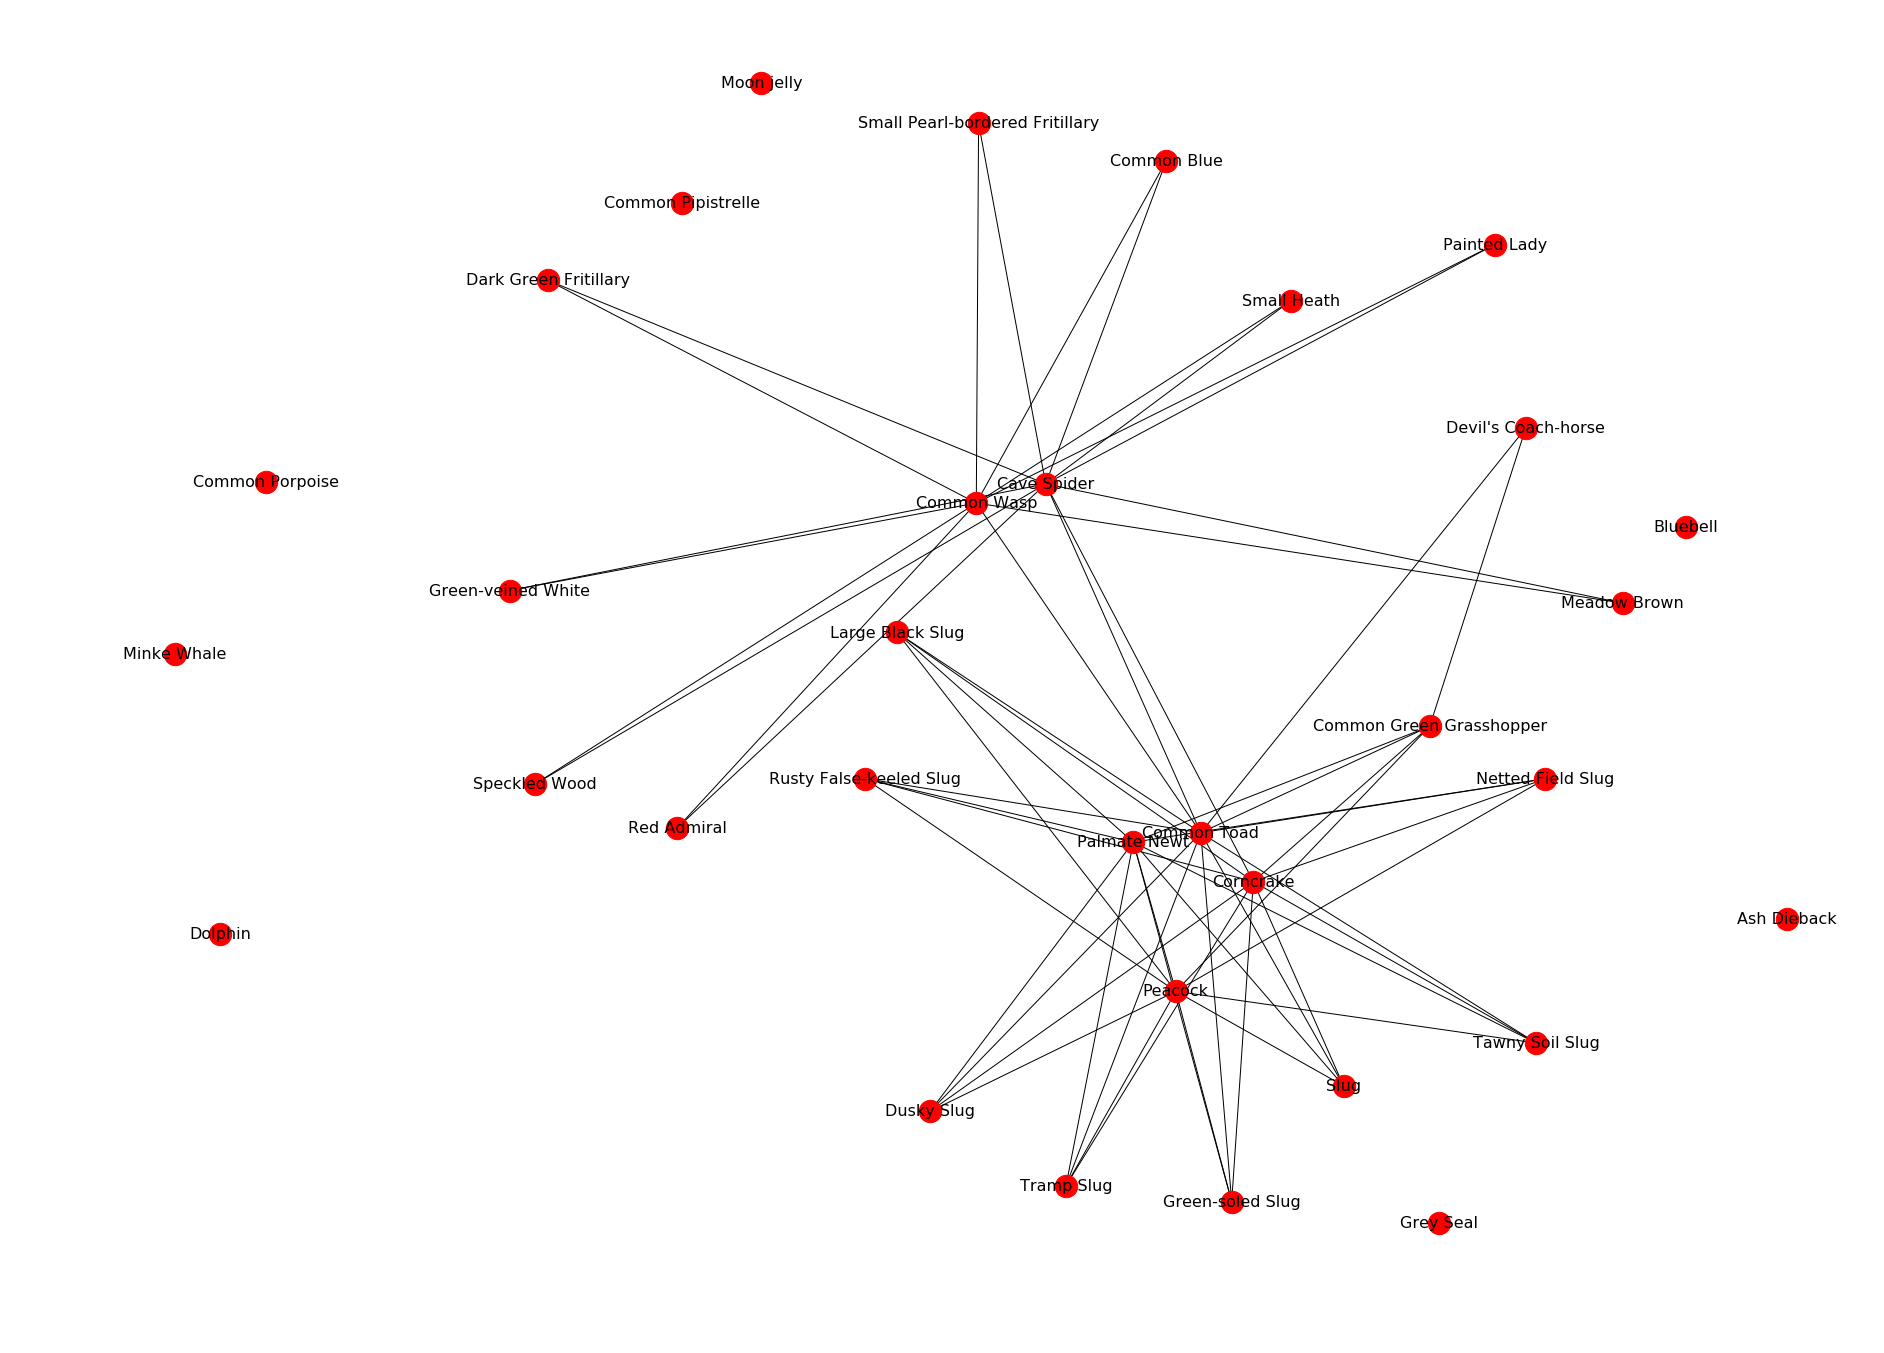

In [37]:
pos=nx.spring_layout(G,k=1)
labels={}
for k,i in enumerate(animals): labels[k] = i
nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G, pos, node_size=500)

In [38]:
print(len(G.edges()))

60


In [39]:
file = nx.to_numpy_matrix(G)
print(file.shape)
print()
print(file)
np.savetxt("EcoNetwork.txt",file, "%d")    

(33, 33)

[[ 0.  0.  0. ...,  0.  1.  1.]
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 0.  0.  0. ...,  0.  1.  1.]
 ..., 
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]]


In [40]:
def getLabels():
    dataIn = pd.read_csv("eigg.csv") 
    df1 = dataIn[['Scientific name', 'Common name','Start date year', 'Latitude (WGS84)','Longitude (WGS84)']]
    df1 = df1.dropna(subset=['Start date year'])
    df1 = df1.dropna(subset=['Latitude (WGS84)'])
    df1 = df1.dropna(subset=['Longitude (WGS84)'])
    df1["Start date year"] = df1["Start date year"].astype(np.int32)
    final = df1[(df1['Start date year'] > 2015.0)]
    return list(final['Common name'])

def getProcessedCoordsList():
    dataIn = pd.read_csv("eigg.csv") 
    df1 = dataIn[['Scientific name', 'Common name','Start date year', 'Latitude (WGS84)','Longitude (WGS84)']]
    df1 = df1.dropna(subset=['Start date year'])
    df1 = df1.dropna(subset=['Latitude (WGS84)'])
    df1 = df1.dropna(subset=['Longitude (WGS84)'])
    df1["Start date year"] = df1["Start date year"].astype(np.int32)
    final = df1[(df1['Start date year'] > 2015.0)]
    res = list(zip(final["Latitude (WGS84)"], final['Longitude (WGS84)']))
    res = list(map(lambda x: list(map(lambda y: float(y),x)),res))
    return res

def buildPlottableGraph(G,animals):
    dataIn = pd.read_csv("eigg.csv") 
    df1 = dataIn[['Scientific name', 'Common name','Start date year', 'Latitude (WGS84)','Longitude (WGS84)']]
    df1 = df1.dropna(subset=['Start date year'])
    df1 = df1.dropna(subset=['Latitude (WGS84)'])
    df1 = df1.dropna(subset=['Longitude (WGS84)'])
    df1["Start date year"] = df1["Start date year"].astype(np.int32)
    final = df1[(df1['Start date year'] > 2015.0)]
    final.reset_index(inplace=True)
    locs = []
    
    for animal in animals:
        targeted = None
        if animal == "Dolphin":
            targeted = final[final['Scientific name'] == "Delphinidae"].index.tolist()
        elif animal == "Slug":
            targeted = final[final['Scientific name']=="Arion (Carinarion) circumscriptus"].index.tolist()
        else:
            targeted = final[final['Common name']==animal].index.tolist()
        locs.append(targeted)

    Gn = nx.Graph()
    for (_from,_to) in G.edges():
        locsF = locs[_from]
        locsT = locs[_to]
        
        for loc1 in locsF:
            for loc2 in locsT:
                Gn.add_edge(loc1,loc2)
    return (getProcessedCoordsList(),Gn)

lst = []
x1 = len(getProcessedCoordsList())
labels = getLabels()
for l in labels:
    if not (type(l) == str):
        lst.append("NA")
    else:
        lst.append(str(l))

generateMapJSON([('./binoculars/marker2.png',getProcessedCoordsList(),lst,[0.01]*x1)],[buildPlottableGraph(G,animals)],'ecoNet.txt')

C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2808: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
def buildBusinessGraph(inferred=False):
    G = nx.Graph()
    data = uninferredNamesGraph()
    if inferred:
        data = inferredNamesGraph()
    
    names = data.keys()
    businesses = list(Counter([item for sublist in data.values() for item in sublist]).keys())
    
    businessMembers = defaultdict(list)
    for b in businesses:
        for name in names:
            if b in data[name]:
                businessMembers[b].append(name)
            
    businessList = businessMembers.keys()
    for k,i in enumerate(businessList): G.add_node(i)
    for b1 in businessList:
        for b2 in businessList:
            if b1 != b2 and len(list(set(businessMembers[b1]) & set(businessMembers[b2]))):
                G.add_edge(b1,b2)
    
    labels={}
    for k,i in enumerate(businessList): labels[i] = i
    return G, labels

d = inferredBusinessLocations()
dict_ = {}

for item in d:
    one,two = d[item].split(",")
    dict_[item] = [float(one),float(two)]

Gb, labels= buildBusinessGraph(inferred=True)

#generateMapJSON([('./fullColMarkers/marker76.png',list(dict_.values()),list(dict_.keys()))],[(dict_,G)],'businessByLocation.txt')
ecoTuple = ('./binoculars/marker2.png',getProcessedCoordsList(),lst,[0.01]*x1)
businessTuple = ('./fullColMarkers/marker76.png',list(dict_.values()),list(dict_.keys()))

interData, interG = buildPlottableGraph(G,animals)
graphTupleAnimals = ('#32CD32',interData,interG)

generateMapJSON([ecoTuple,businessTuple],[('#FFDF00',dict_,Gb),graphTupleAnimals],'ecoOnObs.txt')

C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Proximity based linking

Harder to define; can do so based on one of two things:

* Cluster distance => Define clusters and any animal in that cluster links to another. Is this that usefull?
* At least one interaction to the other animal/ in range proximity somewhere on the island

Option two made more sense. Procedure is as follows:

* Define an "Inspectable area" => this is a centroid and area from the centroid that we should look at 
* Store all lat/lons of each animal
* Drop any if they fall outside of the inspectable area
* Within that area, link the animals if they end up anywhere on the island within some kind of proximity

In [61]:
data = pd.read_csv("eigg.csv") 

C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
# technically doesnt count the fact the earth isnt a sphere
def seperationInMetres(p1,p2):
    R = 6373.0
    
    lat1,lon1 = p1
    lat2, lon2 = p2
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #convert to metres
    return distance * 1000 

def withinInspectableArea(centroid, p1, maxDistanceAway):
    return seperationInMetres(p1,centroid) <= maxDistanceAway

In [63]:
centroid = (56.907887,-6.1960333) #Eigg central
maxDistance = 10000 # Take everything

df = data[['Scientific name', 'Common name', 'Latitude (WGS84)', 'Longitude (WGS84)', 'Start date year']]
df = df[(df['Start date year'] > 2015.0)]

df = df.dropna(subset=['Latitude (WGS84)'])
df = df.dropna(subset=['Longitude (WGS84)'])
df["Latitude (WGS84)"] = df["Latitude (WGS84)"].astype(np.float32)
df["Longitude (WGS84)"] = df["Longitude (WGS84)"].astype(np.float32)

df = df[df.apply(lambda x: withinInspectableArea(centroid,(x['Latitude (WGS84)'],x['Longitude (WGS84)']),maxDistance), axis=1)]

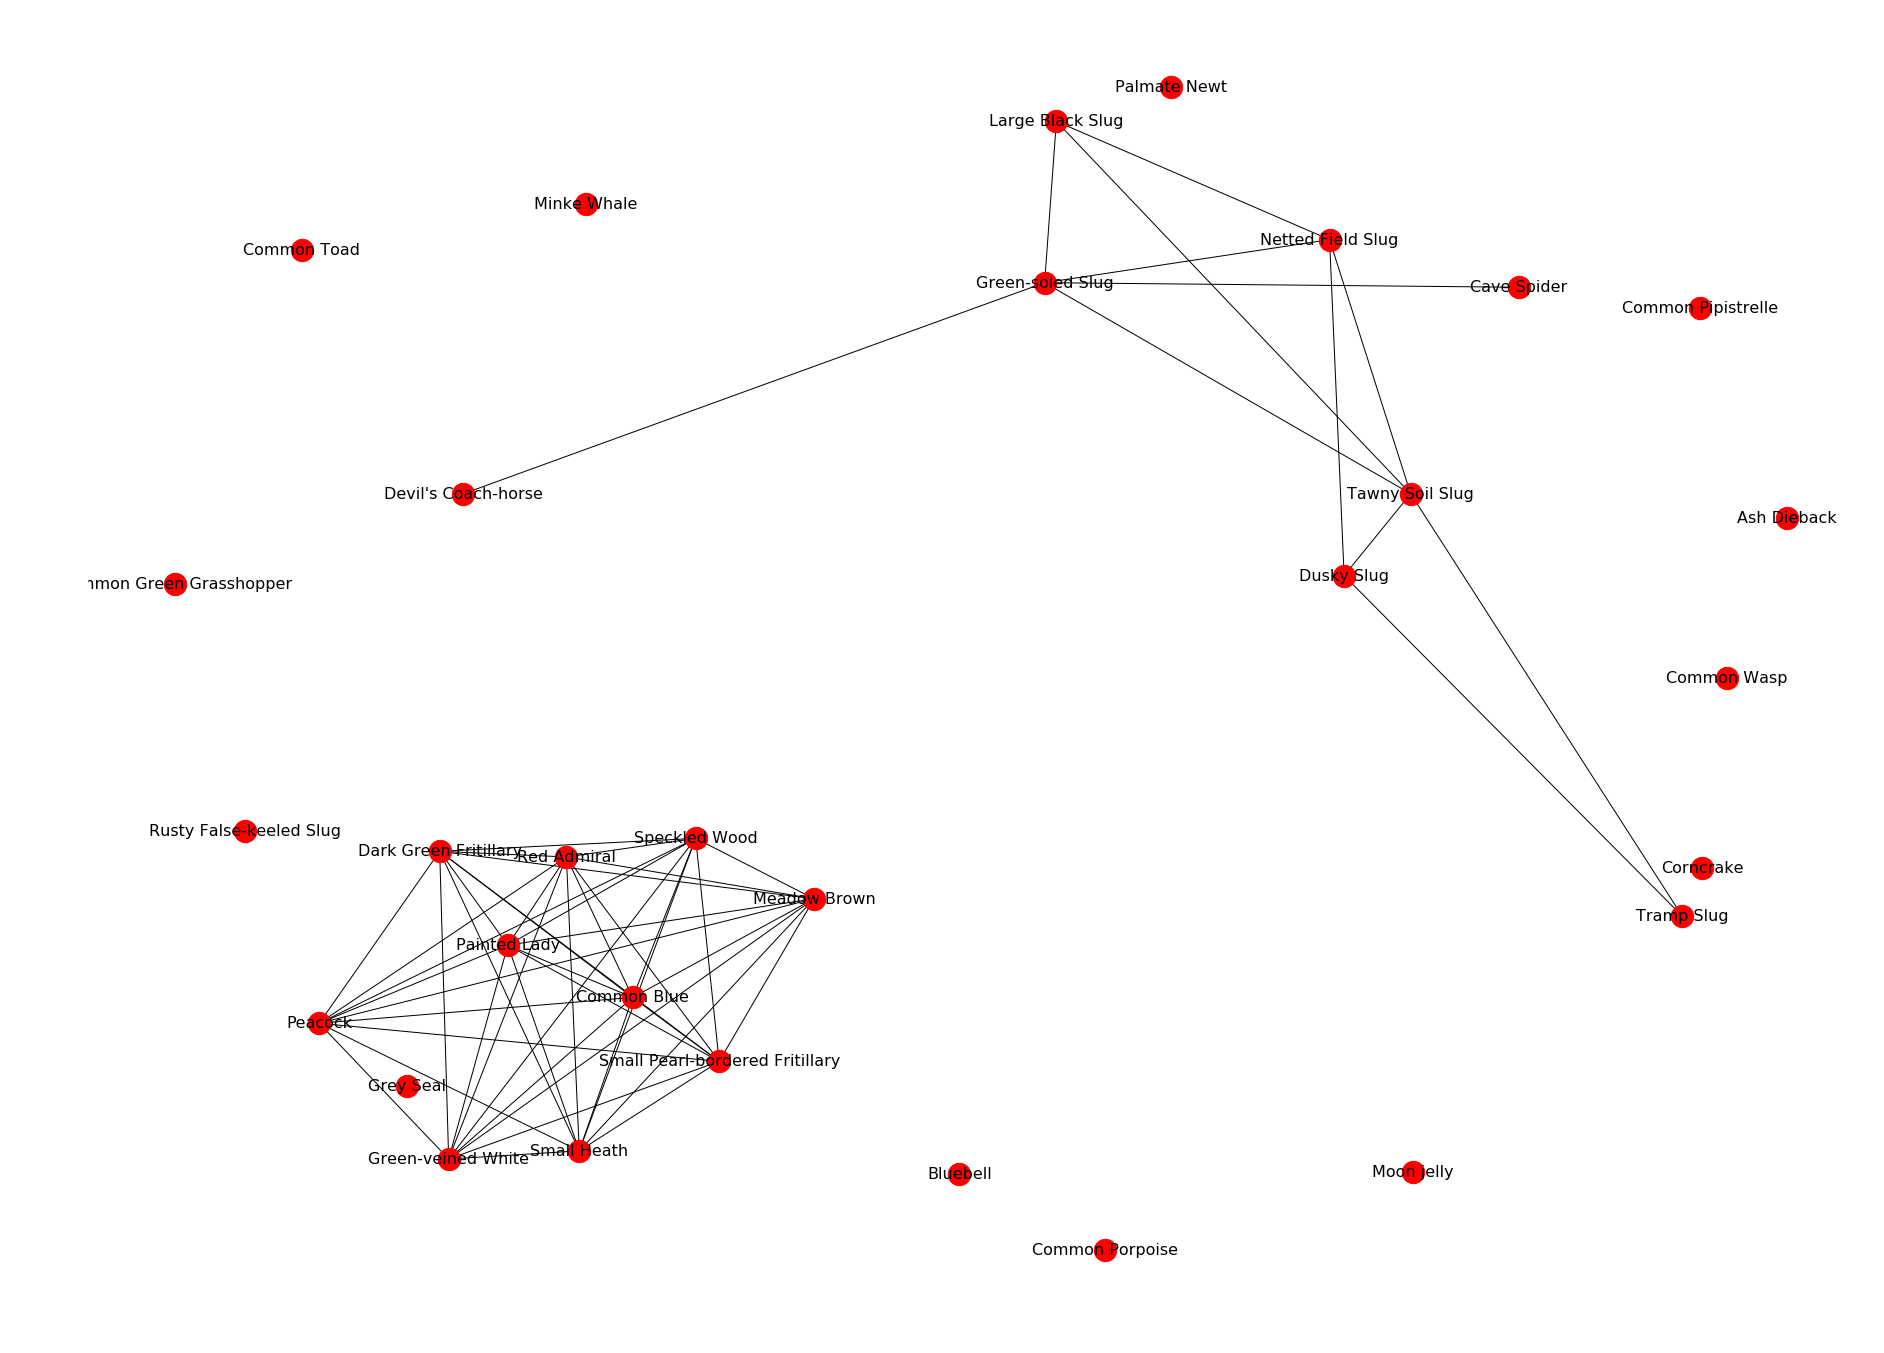

In [64]:
maxDist = 100 #anything within 1000 metres observed is counted

def retrieveAnimals(df):
    main = df['Common name'].unique()
    return list(filter(lambda x: type(x) == str,main))

def retrieveAnimalLocations(df):
    animals = retrieveAnimals(df)
    locs = {}
    for animal in animals:
        entries = df[df['Common name'] == animal]
        locations = zip(entries['Latitude (WGS84)'], entries['Longitude (WGS84)'])
        locations = set(locations)
        locs[animal] = locations
    
    return locs

def animalCloseTo(animal, animalLocs):
    currEntries = animalLocs[animal]
    remainder = animalLocs.keys()
    ret = []
    for k,an in enumerate(remainder):
        if an != animal:
            targetEntries = list(animalLocs[an])
            breakYet = False
            for entry1 in currEntries:
                for entry2 in targetEntries:
                    if seperationInMetres(entry1,entry2) <= maxDist:
                        ret.append(k)
                        breakYet = True
                        break
                if breakYet:
                    break
    return ret

def buildGraph(df):    
    animals = retrieveAnimals(df)
    
    G = nx.Graph()
    labels={}
    for k,i in enumerate(animals): labels[k] = i
    
    for k,i in enumerate(animals): G.add_node(k)
    animalToLatLonMapping = retrieveAnimalLocations(df)
    for k,a in enumerate(animals):
        closeTo = animalCloseTo(a, animalToLatLonMapping)
        for c in closeTo:
            G.add_edge(k,c)
    return G, labels

G, labels = buildGraph(df)
pos=nx.spring_layout(G,k=1)
nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G, pos, node_size=500)
#nx.draw(G)

# Hybrid-Additions: Edge existing on Proximity & Food Web

Is essentially a restricted food web; an edge is only added as long as an observation of that creature took place near another [aka there is the possibility of an interaction happening practically] AND that there would be a food web interaction in theory if they came together

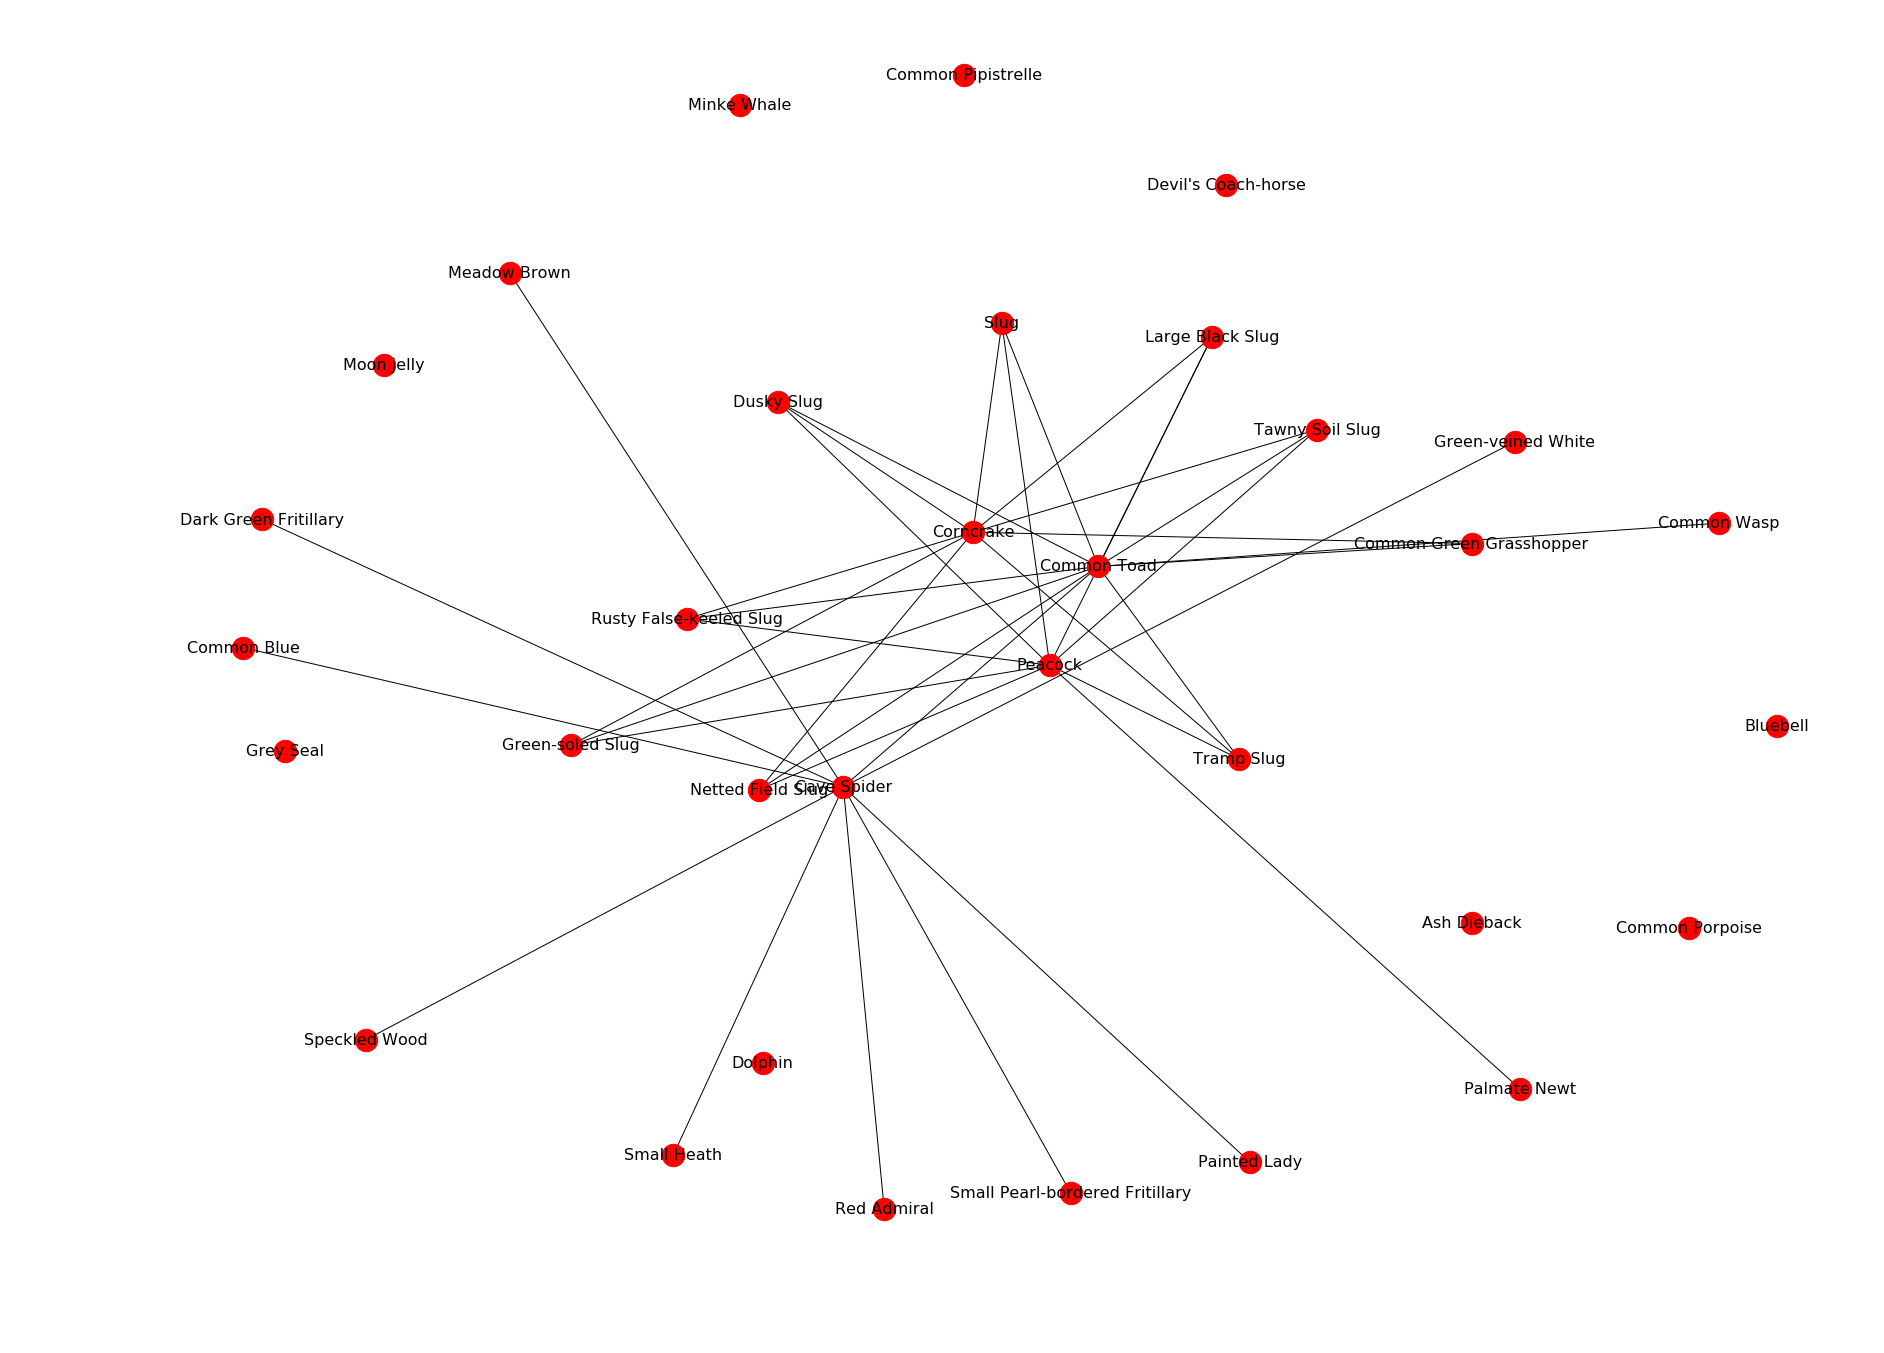

In [72]:

def addToGraph(Gm, from_,to_):
    for f in from_:
        for t in to_:
            Gm.add_edge(f,t)

def removeUnprovenEdges(Gm):
    animals = retrieveAnimals(df)
    animalToLatLonMapping = retrieveAnimalLocations(df)
    for k,a in enumerate(animals):
        closeTo = set(animalCloseTo(a, animalToLatLonMapping))
        currAnimalEdges = Gm.edges(k)
        removalList = []
        for _from,_to in currAnimalEdges:
            if _to not in closeTo:
                removalList.append(_to)
        for item in removalList:
            try:
                Gm.remove_edge(k,_to)
            except:pass

G = nx.Graph()
for k,i in enumerate(mapping): G.add_node(k)

def addToGraph(Gm, from_,to_):
    for f in from_:
        for t in to_:
            Gm.add_edge(f,t)

addToGraph(G,peacocks,slugs+newts+grasshopper)
addToGraph(G,toads,slugs+grasshopper+spiders+wasps+beetles)
addToGraph(G,birds,slugs+grasshopper+spiders)
addToGraph(G,newts,slugs+grasshopper)
addToGraph(G,spiders,butterflies)
addToGraph(G,beetles,grasshopper)
addToGraph(G,wasps,butterflies)

removeUnprovenEdges(G)

pos=nx.spring_layout(G,k=1)
labels={}
for k,i in enumerate(animals): labels[k] = i
nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G, pos, node_size=500)


In [73]:
print(len(G.edges()))

38
